<a href="https://colab.research.google.com/github/etorresram/Sample_Code_Job_Postings_Analytics/blob/main/job_postings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mapping Digital Skills Demand: An NLP Analysis of Job Postings from Google Careers in Argentina**:


**Author**: Eric Torres

This sample code is designed to identify and analyze the digital skills extracted from job postings in Argentina for the period from January to July 2023. In the first part, an initial exploratory analysis is conducted with basic visualizations to extract relevant data from the job postings. In the second part, we delve into the identification and analysis of the digital skills demanded by the job market during the period in which the data was extracted using web scraping techniques.



## **Roadmap**
**1. Exploring Job postings Insights:  Trends and Metrics**

**2. Analizing Digital Skills: Unsupervised ML approach with text clustering based on NLP**

## **1. Exploring Job postings Insights:  Trends and Metrics**

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
sns.set(style="darkgrid")
sns.set_theme()

## **Loading the data**

In [45]:
df_arg = pd.read_parquet('/content/data.parquet')
df_arg.columns.to_list()

['date_posted', 'firm', 'descrip', 'source', 'city', 'zones']

## **List of variables**
**'date_posted'**: Date on which the job vacancy was posted.<br>
**'firm'**: Company posting the job vacancy.<br>
**'descrip'**: Full description of the job vacancy.<br>
**'source'**: Platform where the job vacancy was originally posted.<br>
**'city'**: Location where the job is required.<br>
**'zones'**: Level of knowledge and experience required for the position.<br>

## **Trends of job postings**

<ipython-input-3-e15145dcd4f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])


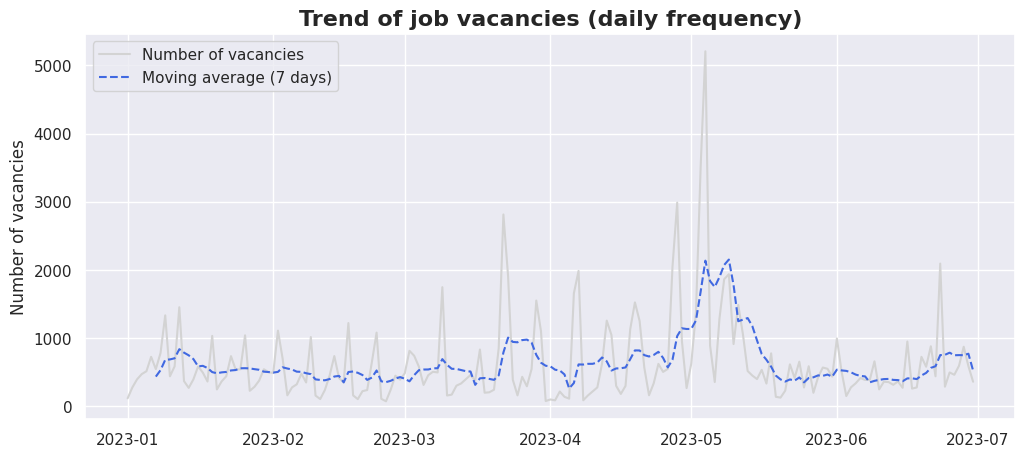

In [3]:
df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])

date_counts = df_arg['date_posted'].value_counts().reset_index()
date_counts.columns = ['Date', 'Number of vacancies']
date_counts = date_counts.sort_values('Date')
date_counts['Moving average'] = date_counts['Number of vacancies'].rolling(window=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(date_counts['Date'], date_counts['Number of vacancies'], marker='', linestyle='-', color='lightgrey', label='Number of vacancies')
plt.plot(date_counts['Date'], date_counts['Moving average'], linestyle='--', color='royalblue', label='Moving average (7 days)')
plt.title('Trend of job vacancies (daily frequency)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('Number of vacancies')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

## **Platforms**
Google Careers collects job vacancies from various platforms.

In [4]:
source_counts = df_arg["source"].value_counts().reset_index()
source_counts.columns = ['source', 'counts']


In [5]:
# Here we correct the names to prevent category duplication
df_arg['source'] = df_arg['source'].replace({
    'a través de Sercanto': 'Sercanto',
    'via Sercanto': 'Sercanto',
    'a través de BeBee': 'BeBee',
    'via BeBee': 'BeBee',
    'a través de LinkedIn': 'LinkedIn',
    'a través de via LinkedIn': 'LinkedIn',
    'a través de Bumeran': 'Bumeran',
    'a través de Computrabajo': 'Computrabajo',
    'a través de Trabajo.org': 'Trabajo.org',
    'a través de Jobrapido.com': 'Jobrapido.com',
    'a través de Universia': 'Universia',
    'a través de Kit Empleo': 'Kit Empleo',
    'a través de Glassdoor': 'Glassdoor',
    'a través de Indeed Argentina': 'Indeed Argentina',
    'a través de Computrabajo Argentina': 'Computrabajo',
    'a través de Trabajo.org - Vacantes De Empleo, Trabajo': 'Trabajo.org',
    'a través de Randstad': 'Randstad',
})

<ipython-input-5-ed404c4e8d17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['source'] = df_arg['source'].replace({


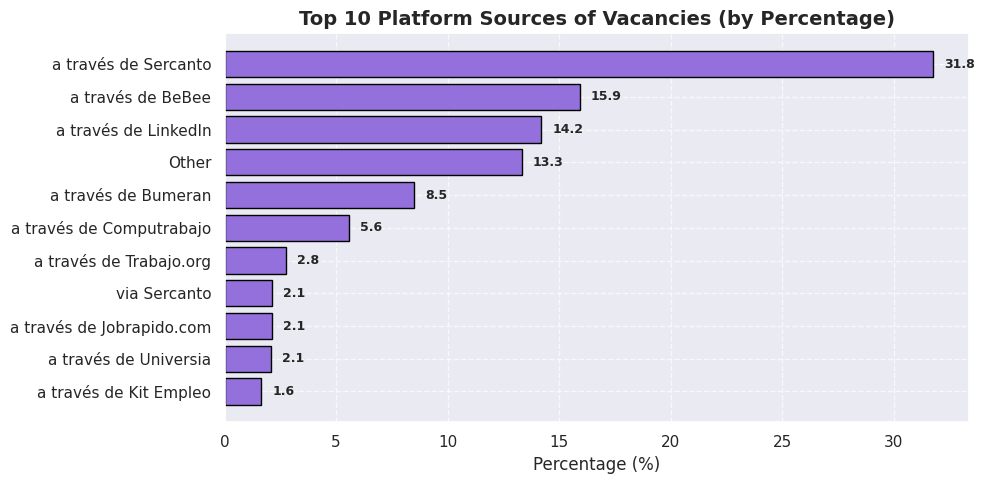

In [6]:
source_counts['percentage'] = (source_counts['counts'] / source_counts['counts'].sum()) * 100

top_10 = source_counts.sort_values(by='percentage', ascending=False).head(10)
other = pd.DataFrame({
    'source': ['Other'],
    'counts': source_counts.iloc[10:]['counts'].sum(),
    'percentage': source_counts.iloc[10:]['percentage'].sum()
})

final_counts = pd.concat([top_10, other], ignore_index=True).sort_values(by='percentage', ascending=True)

plt.figure(figsize=(10, 5))
bars = plt.barh(final_counts['source'], final_counts['percentage'], color='mediumpurple', edgecolor='black')

for bar, pct in zip(bars, final_counts['percentage']):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{pct:.1f}',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Top 10 Platform Sources of Vacancies (by Percentage)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Telework identification**

In [7]:
import re

# Telework keywords
keywords = [
    'teletrabajo', 'trabajo remoto', 'modalidad mixta', 'home office',
    'trabajo a distancia', 'trabajo en casa', 'trabajo virtual',
    'trabajo híbrido', 'híbrida', 'híbrido', 'trabajo desde el hogar'
]

def normalize_keyword(keyword):
    return (
        keyword.lower()
        .replace('á', '[aá]')
        .replace('é', '[eé]')
        .replace('í', '[ií]')
        .replace('ó', '[oó]')
        .replace('ú', '[uú]')
    )

pattern = '|'.join([normalize_keyword(kw) for kw in keywords])

df_arg['telework'] = df_arg['descrip'].str.lower().str.contains(pattern, regex=True, na=False).astype(int)

<ipython-input-7-8fcbcbd33d3e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['telework'] = df_arg['descrip'].str.lower().str.contains(pattern, regex=True, na=False).astype(int)


<ipython-input-8-1dcf2be30090>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])
<ipython-input-8-1dcf2be30090>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['year_month'] = df_arg['date_posted'].dt.strftime('%b-%Y').str.lower()


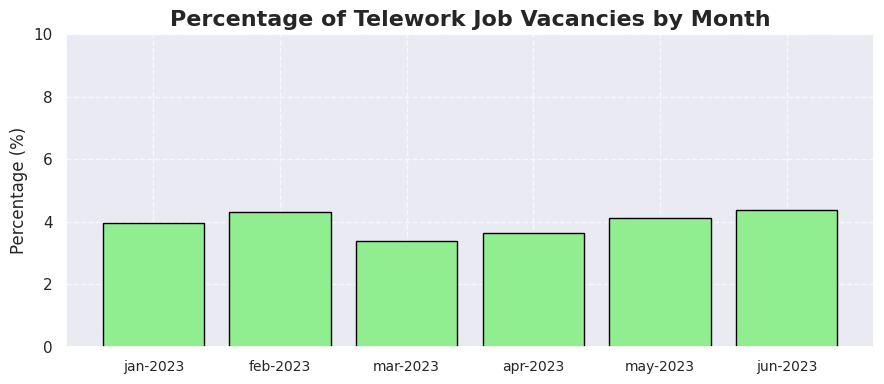

In [8]:
df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])
df_arg['year_month'] = df_arg['date_posted'].dt.strftime('%b-%Y').str.lower()

monthly_telework = (
    df_arg.groupby('year_month')['telework']
    .agg(['sum', 'count'])
    .assign(percentage=lambda x: (x['sum'] / x['count']) * 100)
    .reset_index()
)

monthly_telework['date_order'] = pd.to_datetime(monthly_telework['year_month'], format='%b-%Y')
monthly_telework = monthly_telework.sort_values(by='date_order')

plt.figure(figsize=(9, 4))
plt.bar(
    monthly_telework['year_month'],
    monthly_telework['percentage'],
    color='lightgreen',
    edgecolor='black'
)

plt.title('Percentage of Telework Job Vacancies by Month', fontsize=16, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 10)
plt.xticks(rotation=0, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **Job postings by city**
According to the chart, the "Other" category accounts for 54.8%, which does not seem to make sense since Buenos Aires and Córdoba are the largest cities. The city field was correctly extracted during the web scraping process, but the city names are not standardized. This requires a deeper analysis, which I will not address in this code, as I will focus on skills.

In [9]:
city_counts = df_arg["city"].value_counts().reset_index()
city_counts.columns = ['city', 'counts']

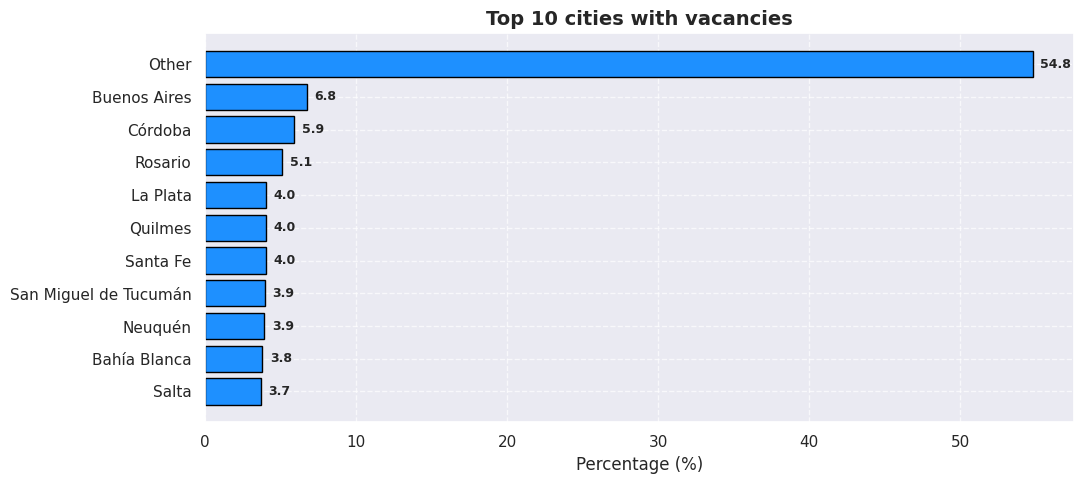

In [10]:
city_counts['percentage'] = (city_counts['counts'] / city_counts['counts'].sum()) * 100

top_10 = city_counts.sort_values(by='percentage', ascending=False).head(10)
other = pd.DataFrame({
    'city': ['Other'],
    'counts': city_counts.iloc[10:]['counts'].sum(),
    'percentage': city_counts.iloc[10:]['percentage'].sum()
})

final_counts = pd.concat([top_10, other], ignore_index=True).sort_values(by='percentage', ascending=True)

plt.figure(figsize=(11, 5))
bars = plt.barh(final_counts['city'], final_counts['percentage'], color='dodgerblue', edgecolor='black')

for bar, pct in zip(bars, final_counts['percentage']):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{pct:.1f}',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Top 10 cities with vacancies', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Required qualifications**

In [11]:
df_arg['zones'] = df_arg['zones'].replace(zone_labels := {
    1: 'Low or no qualification',
    2: 'Some qualification',
    3: 'Medium qualification',
    4: 'High qualification',
    5: 'Expert-level qualification'
})

<ipython-input-11-f5bc65f6bc9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['zones'] = df_arg['zones'].replace(zone_labels := {


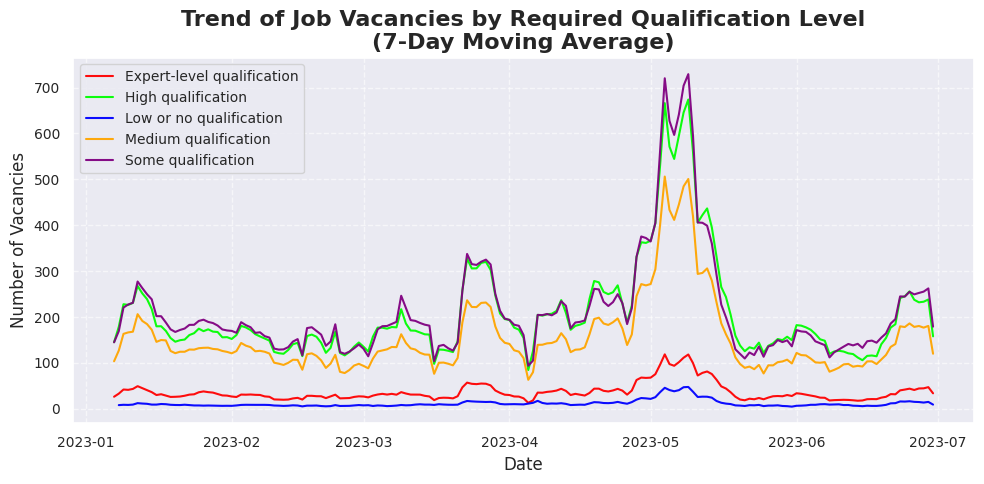

In [12]:
colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080',
    '#00FFFF', '#FFD700', '#FF1493', '#00FF7F', '#1E90FF' ]


date_counts = df_arg.groupby(['zones', 'date_posted']).size().reset_index(name='conteo_fechas')
date_counts['media_movil'] = date_counts.groupby('zones')['conteo_fechas'].rolling(window=7).mean().reset_index(0, drop=True)
filtered_counts = date_counts[date_counts['zones'].isin(zone_labels.values())]


plt.figure(figsize=(10, 5))

for (area, data), color in zip(filtered_counts.groupby('zones'), colors):
    plt.plot(
        data['date_posted'],
        data['media_movil'],
        label=zone_labels.get(area, area),
        linewidth=1.5,
        alpha=0.95,
        color=color
    )

plt.title('Trend of Job Vacancies by Required Qualification Level\n(7-Day Moving Average)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Vacancies', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

## **2. Analizing Digital Skills: Unsupervised ML approach with text clustering based on NLP**

## **Digital skills Identification**

In [13]:
digital_skills_list = [
    # Programming languages
    "python", "r", "sql", "java", "scala", "c++", "c#", "julia", "matlab", "javascript", "typescript", "php", "go", "rust", "ruby", "bash", "perl",
    # Data analysis tools
    "excel", "power bi", "tableau", "looker", "sas", "spss", "stata", "alteryx", "rapidminer", "matplotlib", "seaborn", "plotly", "dash", "d3.js",
    # Cloud and DevOps tools
    "aws", "azure", "gcp", "google cloud", "terraform", "kubernetes", "docker", "jenkins", "ansible", "puppet", "heroku", "cloudformation", "databricks",
    # Big Data & Machine Learning
    "spark", "hadoop", "hive", "kafka", "pig", "tensorflow", "pytorch", "scikit-learn", "keras", "xgboost", "lightgbm", "mlflow", "h2o.ai", "sagemaker"
    # Databases
    "mysql", "postgresql", "oracle", "sql server", "sqlite", "mongodb", "cassandra", "neo4j", "redis", "dynamodb", "bigquery", "snowflake", "redshift",
    # Collaboration and automation tools
    "git", "github", "gitlab", "bitbucket", "jira", "confluence", "zapier", "airflow", "nifi", "sentry", "selenium", "appium", "robot framework",
    # Platforms and services
    "power automate", "service now", "salesforce", "sap", "workday", "hubspot", "zendesk", "mailchimp", "sharepoint", "notion", "trello", "asana",
    # NLP and text processing tools
    "spacy", "nltk", "gensim", "transformers", "openai api", "llamaindex", "huggingface", "bert", "gpt", "llms", "roberta", "jupyter", "knime", "datarobot",
    "autocad", "revit", "solidworks", "sketchup", "ansys", "etabs", "civil 3d", "staad.pro",
    # Graphic Design and Multimedia
    "photoshop", "illustrator", "indesign", "coreldraw", "figma", "sketch", "blender", "cinema 4d", "procreate", "affinity designer",
    # Finance and Accounting
    "quickbooks", "xero", "sage 50cloud", "bloomberg terminal",
    # Data Science and Analytics
    "jupyter notebooks", "knime", "datarobot",
    # Healthcare and Medicine
    "epic systems", "cerner", "meditech", "mckesson", "snomed ct", "pacs", "athenahealth", "openemr",
    # Marketing and Sales
    "marketo", "ahrefs", "semrush", "hootsuite", "activecampaign",
    # Education and E-learning
    "moodle", "google classroom", "edmodo", "blackboard", "kahoot", "articulate 360", "canvas lms", "edpuzzle", "quizizz",
    # Software Development and IT
    "visual studio code", "pycharm", "eclipse", "intellij idea", "postman",
    # Logistics and Inventory Management
    "sap scm", "oracle scm cloud", "manhattan associates", "blue yonder", "fishbowl inventory", "netsuite erp",
    # Cybersecurity
    "wireshark", "metasploit", "nmap", "snort", "kali linux", "splunk", "bitdefender gravityzone",
    # Other relevant technical concepts
    "api", "rest api", "graphql", "microservices", "ci/cd", "web scraping", "etl", "data pipeline", "big data", "machine learning", "deep learning",
    "artificial intelligence", "computer vision", "natural language processing", "word", "power point", "microsoft teams", "corel", "vscode",
]

pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in digital_skills_list) + r')\b'

def extract_skills(description):
    if pd.isna(description):
        return []
    found_skills = set(re.findall(pattern, description.lower()))
    return sorted(found_skills)

df_arg['digital_skills'] = df_arg['descrip'].apply(extract_skills)


<ipython-input-13-d11f12c198ea>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['digital_skills'] = df_arg['descrip'].apply(extract_skills)


In [14]:
df_arg[['descrip', 'digital_skills']].head(10)

,descrip,digital_skills
0,MEDICOS SIN FRONTERAS – SECCIÓN MSF LAT busca:...,[sap]
1,"En Telefónica- Movistar, tenemos como Misión h...","[oracle, sql]"
2,No hemos encontrado nada para tu búsqueda\n\nL...,"[excel, r]"
3,Local Unit & Position Description\n\nAre you D...,[word]
4,Somos una empresa de industria nacional que br...,"[api, autocad, excel, sap, word]"
5,Descripción del empleo\nOverview of Libertex A...,[salesforce]
6,Service Delivery Coordinator – Río Grande (Tie...,[]
7,Service Delivery Coordinator – Río Grande (Tie...,[]
8,Company Description\n\nAt Turner & Townsend we...,[]
9,Job Description\n\nPurpose\n\nThe Argentina Fi...,[]


## **Clustering process of the variable description**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
!pip install umap-learn
import umap.umap_ as umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [16]:
# Step 1: Text preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Remove accents
    text = re.sub(r'[áàäâ]', 'a', text)
    text = re.sub(r'[éèëê]', 'e', text)
    text = re.sub(r'[íìïî]', 'i', text)
    text = re.sub(r'[óòöô]', 'o', text)
    text = re.sub(r'[úùüû]', 'u', text)
    # Remove punctuation, digits, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
df_arg['clean_descrip'] = df_arg['descrip'].apply(preprocess_text)

# Step 2: Define Spanish stop words
spanish_stopwords = {
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una',
    'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre',
    'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos',
    'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí',
    'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho',
    'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros','hs',
    'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío','hace',
    'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro','san',
    'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy',
    'estás', 'está', 'estamos', 'estáis', 'están', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis',
    'estuvieron', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estuve', 'estuviste', 'estuvo', 'estuvimos',
    'estuvisteis', 'estuvieron', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'teníamos', 'teníais',
    'tenían', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'vos', 'es', 'ser', 'mas', 'aos', 'si'
}

combined_stopwords = list(text.ENGLISH_STOP_WORDS.union(spanish_stopwords))

vectorizer = TfidfVectorizer(max_features=3000, stop_words=combined_stopwords)
X = vectorizer.fit_transform(df_arg['clean_descrip'])

terms = vectorizer.get_feature_names_out()
print("🔍 Sample terms after preprocessing and stopword removal:", terms[:20])

<ipython-input-16-abe30b8bf562>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['clean_descrip'] = df_arg['descrip'].apply(preprocess_text)


🔍 Sample terms after preprocessing and stopword removal: ['abastecimiento' 'ability' 'able' 'abril' 'academica' 'academico'
 'accede' 'acceder' 'accenture' 'acceso' 'accesorios' 'access'
 'accidentes' 'accion' 'acciones' 'according' 'account' 'accounting'
 'acepta' 'aceptas']


In [17]:
# STEP 3: Apply Clustering (K-means)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_arg['cluster'] = kmeans.fit_predict(X)

<ipython-input-17-c7f2cabfcc5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['cluster'] = kmeans.fit_predict(X)


In [18]:
# STEP 4: Dimensionality Reduction (UMAP)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = umap_reducer.fit_transform(X)

df_arg['x'] = embedding[:, 0]
df_arg['y'] = embedding[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
<ipython-input-18-430c73ac01b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arg['x'] = embedding[:, 0]
<i

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


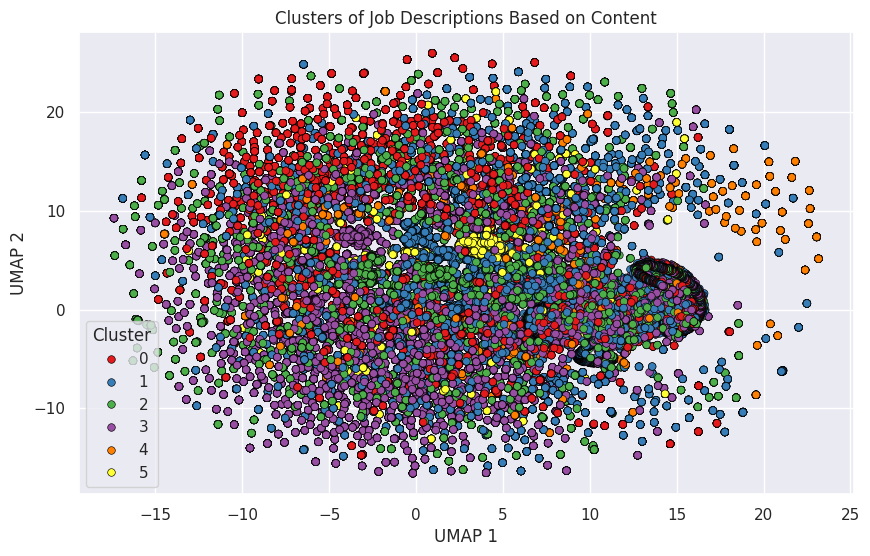

In [20]:
# STEP 5: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=df_arg, palette='Set1', edgecolor='black', s=30)
plt.title('Clusters of Job Descriptions Based on Content')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# **Finding topics by cluster**

# Word Frequency per Cluster

**Main findings:**
* **Cluster 0** contains many words related to sales, clients, commerce, and products (likely jobs in the retail sector).
* **Cluster 1** includes words like remote, data, and team (it might include people with more digital skills).
* **Cluster 3** has words associated with management, control, quality, and development (likely related to leadership and administrative activities).
* **Cluster 4** contains the words that most frequently appear in job postings written in English.




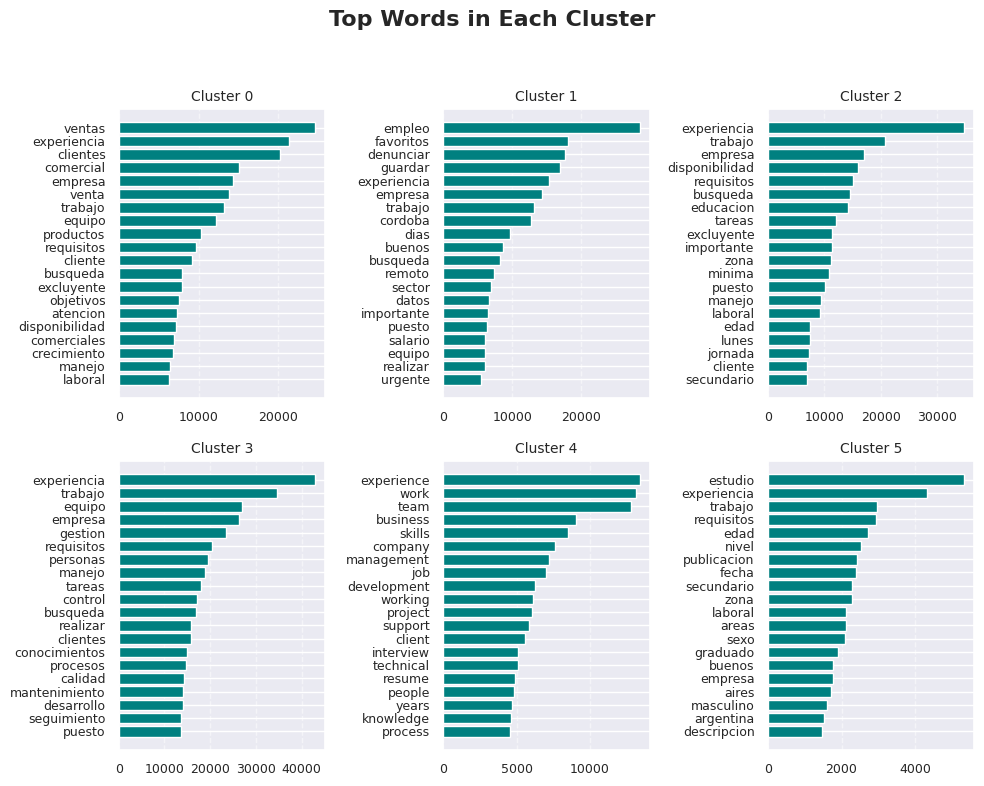

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=combined_stopwords, max_features=20)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Top Words in Each Cluster', fontsize=16, fontweight='bold')

for idx, cluster_num in enumerate(sorted(df_arg['cluster'].unique())):
    cluster_text = " ".join(df_arg[df_arg['cluster'] == cluster_num]['clean_descrip'])
    word_counts = vectorizer.fit_transform([cluster_text])
    words = vectorizer.get_feature_names_out()
    counts = word_counts.toarray()[0]
    word_freq = pd.DataFrame({'word': words, 'count': counts}).sort_values(by='count', ascending=False)

    ax = axes[idx // 3, idx % 3]

    ax.barh(word_freq['word'], word_freq['count'], color='teal')
    ax.set_title(f'Cluster {cluster_num}', fontsize=10)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# * Digital Skills Distribution by Cluster



**Main findings:**
* The digital skills required in **Cluster 0** seem to align with the assumption made in the previous chart, suggesting that these are jobs in the retail sales sector, as Word, Salesforce, and SAP stand out.
* Along those lines, **Cluster 1** shows a higher demand for digital skills related to database management, with SQL being particularly prominent. However, it appears that **Cluster 4** is the one that truly demands digital skills for database management, data architecture, and software development (Python, JavaScript, SQL, and AWS). This makes sense, as these job postings are in English, likely targeting data engineers and software specialists for remote work.
* **Cluster 3** indeed requires digital skills for people organization and operations management.
* Finally, the skills in **Cluster 5** appear to be more associated with jobs for graphic designers, as AutoCAD, SolidWorks, Corel, and Photoshop stand out.



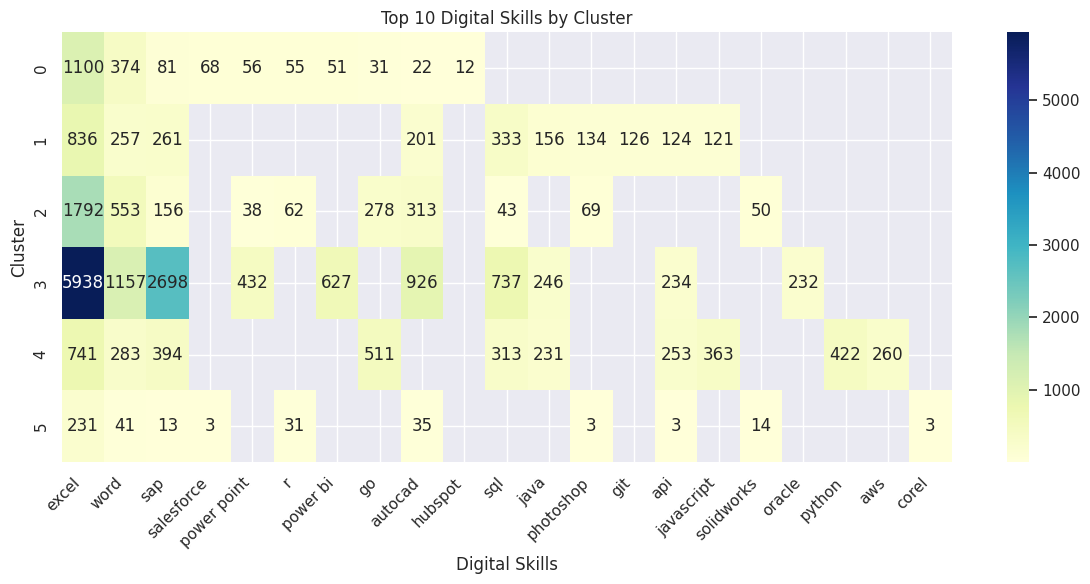

In [43]:
skills_by_cluster = df_arg.groupby('cluster')['digital_skills'].apply(lambda x: sum(x, []))
skills_summary = skills_by_cluster.apply(lambda x: pd.Series(x).value_counts().head(10))

# Visualize the top skills as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(skills_summary, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title("Top 10 Digital Skills by Cluster")
plt.xlabel("Digital Skills")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


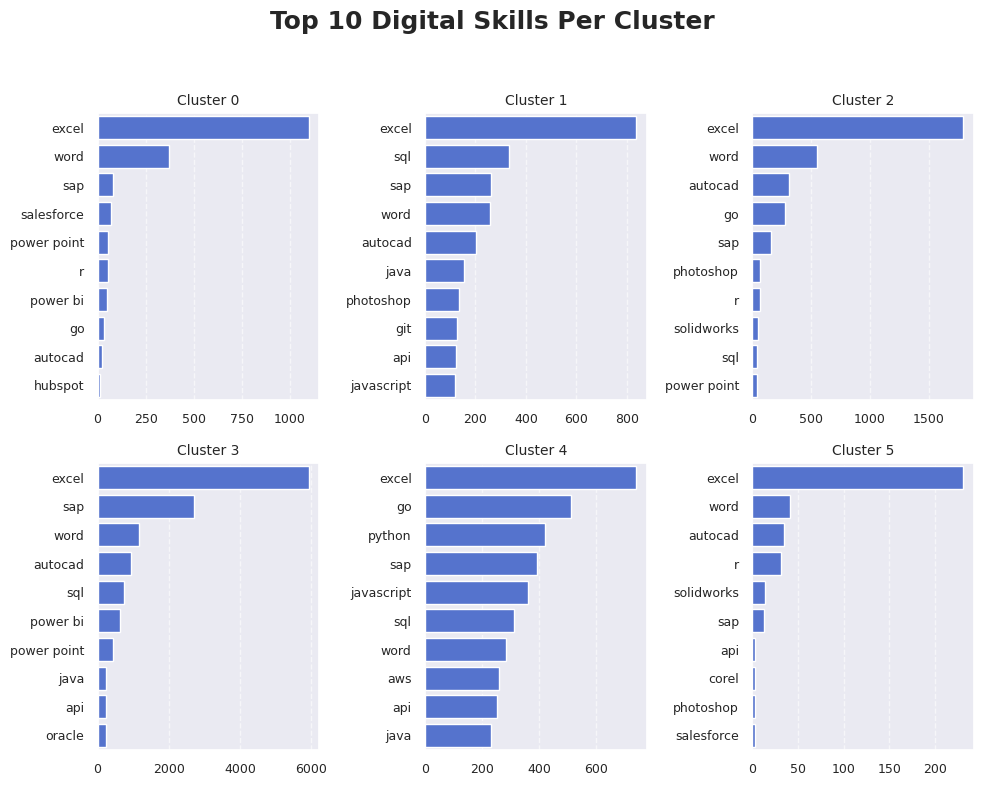

In [39]:
# Prepare top 10 skills per cluster
digital_skills_distribution = df_arg.explode('digital_skills').groupby(['cluster', 'digital_skills']).size().reset_index(name='count')


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Top 10 Digital Skills Per Cluster', fontsize=18, fontweight='bold')

for idx, cluster_num in enumerate(sorted(df_arg['cluster'].unique())):
    ax = axes[idx // 3, idx % 3]
    cluster_data = digital_skills_distribution[digital_skills_distribution['cluster'] == cluster_num]
    top_skills = cluster_data.sort_values('count', ascending=False).head(10)

    sns.barplot(x='count', y='digital_skills', data=top_skills, ax=ax, color='royalblue')
    ax.set_title(f'Cluster {cluster_num}', fontsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

